In [1]:

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from decomposition import DecompositionLayer
torch.set_num_threads(9)

class MyDataset(TensorDataset):
    def __init__(self, data, window):
        self.data = data
        self.window = window

    def __getitem__(self, index):
        x = self.data[index:index+self.window]
        return x

    def __len__(self):
        return len(self.data) - self.window

In [2]:
input_size = 150
pred = input_size
learning_rate = 0.0001

data_size  = 4000
step = 10
m = 100 #на сколько шагов предсказать
data_set = 9000

In [3]:
class DecompositionLayer(nn.Module):
    """
    Returns the trend and the seasonal parts of the time series.
    """

    def __init__(self, kernel_size):
        super().__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=1, padding=0) # moving average 

    def forward(self, x):
        """Input shape: Batch x Time x EMBED_DIM"""
        # padding on the both ends of time series
        num_of_pads = (self.kernel_size) // 2
        front = x[:, 0:1, :].repeat(1, num_of_pads, 1)
        end = x[:, -1:, :].repeat(1, num_of_pads, 1)
        x_padded = torch.cat([front, x, end], dim=1)

        # calculate the trend and seasonal part of the series
        x_trend = self.avg(x_padded.permute(0, 2, 1))[:,:,:-1].permute(0, 2, 1)
        #print(x_trend.shape)
        x_seasonal = x - x_trend
        return x_seasonal, x_trend

In [4]:
class DLinearModel(nn.Module):
    def __init__(self, input_size):
        super(DLinearModel, self).__init__()
        self.linear_seasonal = nn.Linear(input_size, 1)
        self.linear_trend = nn.Linear(input_size, 1)
        self.decomposition = DecompositionLayer(input_size)
        self.bias = nn.Parameter(torch.zeros(1))
        
    def forward(self, context):
        seasonal, trend = self.decomposition(context)
        #print(seasonal, trend)
        seasonal_output = self.linear_seasonal(seasonal.reshape(1, 1, -1))
        trend_output = self.linear_trend(trend.reshape(1, 1, -1))
        
        return seasonal_output + trend_output


def train_model(model, dataloader, criterion, optimizer, num_epochs=100):
    for epoch in range(num_epochs):
        print("Epoch = ", epoch)
        for X in dataloader:
            
            optimizer.zero_grad()
            output = model.forward(X)
            loss = criterion(output, X)
            loss.backward()
            optimizer.step()


In [5]:

data = pd.read_csv('ETTh1.csv')  
X = torch.tensor(data['HUFL'].values[:data_size:step], dtype=torch.float32).view(-1, 1)
x = pd.read_csv("ETTh1.csv").HUFL

In [6]:
model = DLinearModel(input_size)
criterion = nn.SmoothL1Loss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate)


window_size = input_size  # Размер окна для rolling window forecasting
#переписать

dataset = MyDataset(X, window_size)

#print(x.rolling(window_size))

dataloader = DataLoader(dataset)#, shuffle=True)

In [7]:
len(dataloader)

250

In [8]:
train_model(model, dataloader, criterion, optimizer)


Epoch =  0
Epoch =  1


c:\Users\evgen\miniconda3\envs\MyDLinear\Lib\site-packages\torch\nn\modules\loss.py:933: UserWarning: Using a target size (torch.Size([1, 150, 1])) that is different to the input size (torch.Size([1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)


Epoch =  2
Epoch =  3
Epoch =  4
Epoch =  5
Epoch =  6
Epoch =  7
Epoch =  8
Epoch =  9
Epoch =  10
Epoch =  11
Epoch =  12
Epoch =  13
Epoch =  14
Epoch =  15
Epoch =  16
Epoch =  17
Epoch =  18
Epoch =  19
Epoch =  20
Epoch =  21
Epoch =  22
Epoch =  23
Epoch =  24
Epoch =  25
Epoch =  26
Epoch =  27
Epoch =  28
Epoch =  29
Epoch =  30
Epoch =  31
Epoch =  32
Epoch =  33
Epoch =  34
Epoch =  35
Epoch =  36
Epoch =  37
Epoch =  38
Epoch =  39
Epoch =  40
Epoch =  41
Epoch =  42
Epoch =  43
Epoch =  44
Epoch =  45
Epoch =  46
Epoch =  47
Epoch =  48
Epoch =  49
Epoch =  50
Epoch =  51
Epoch =  52
Epoch =  53
Epoch =  54
Epoch =  55
Epoch =  56
Epoch =  57
Epoch =  58
Epoch =  59
Epoch =  60
Epoch =  61
Epoch =  62
Epoch =  63
Epoch =  64
Epoch =  65
Epoch =  66
Epoch =  67
Epoch =  68
Epoch =  69
Epoch =  70
Epoch =  71
Epoch =  72
Epoch =  73
Epoch =  74
Epoch =  75
Epoch =  76
Epoch =  77
Epoch =  78
Epoch =  79
Epoch =  80
Epoch =  81
Epoch =  82
Epoch =  83
Epoch =  84
Epoch =  85


In [9]:
torch.save(model.state_dict(), "test_model_v9_15_12_23_17_02")

In [10]:
model.load_state_dict(torch.load("test_model_v9_15_12_23_17_02"))
model.eval()

DLinearModel(
  (linear_seasonal): Linear(in_features=150, out_features=1, bias=True)
  (linear_trend): Linear(in_features=150, out_features=1, bias=True)
  (decomposition): DecompositionLayer(
    (avg): AvgPool1d(kernel_size=(150,), stride=(1,), padding=(0,))
  )
)

In [11]:
model.parameters

<bound method Module.parameters of DLinearModel(
  (linear_seasonal): Linear(in_features=150, out_features=1, bias=True)
  (linear_trend): Linear(in_features=150, out_features=1, bias=True)
  (decomposition): DecompositionLayer(
    (avg): AvgPool1d(kernel_size=(150,), stride=(1,), padding=(0,))
  )
)>

In [12]:
def predict_future_values(model, X_f, window_size, m):
    #predicted_values = initial_values.clone().detach().view(-1).tolist()
    predicted_values = []
    
    for i in range(m):
        
        
        #проверить что модель принимает нужный набор значений
        #last_X = torch.tensor([predicted_values[-1]], dtype=torch.float32).view(-1, 1)
        # last_X_t = torch.tensor([predicted_values[-1]], dtype=torch.float32).view(-1, 1)
        
        prediction = model(X_f)

        
        predicted_values.append(prediction.tolist()[-1][-1][-1])
        if(window_size > i):
            
            X_f = torch.tensor(data['HUFL'].values[data_size-window_size+i+1::step] + predicted_values, dtype=torch.float32).reshape(1, 1, -1)
        else:
            X_f = torch.tensor(predicted_values, dtype=torch.float32).reshape(1, 1, -1)
            
        

    return predicted_values

In [16]:
initial_values = torch.cat([X[-input_size:]]).reshape(1, 1, -1)

pred = input_size
X_f = torch.tensor(data['HUFL'].values[data_set-pred:data_set-pred+pred*step:step], dtype=torch.float32).view(-1, 1)
print(X_f)
dataset_f = MyDataset(X_f, pred)
print(dataset_f.data)
#print(x.rolling(window_size))

dataloader_f = DataLoader(dataset_f)#, shuffle=True)

X_f


tensor([[  7.2340],
        [  9.7790],
        [ -4.4880],
        [ 13.5300],
        [  1.4070],
        [ 13.3290],
        [ 10.3150],
        [  6.8320],
        [ 14.2000],
        [-10.1810],
        [ 10.9850],
        [  7.7030],
        [  6.6310],
        [  9.3770],
        [ -0.4690],
        [ 10.1810],
        [ -9.2430],
        [ 11.8550],
        [  9.3770],
        [ -3.7510],
        [ 13.7980],
        [  3.0140],
        [ 15.6060],
        [  8.7070],
        [ 10.1140],
        [ 11.7880],
        [ -6.8320],
        [ 18.4860],
        [ -0.4020],
        [ 17.5490],
        [ 12.3240],
        [  2.4780],
        [ 15.9410],
        [ -6.8320],
        [ 19.1560],
        [  3.1480],
        [ 10.3150],
        [ 16.2760],
        [ -4.5550],
        [ 19.7590],
        [ -3.5500],
        [ 19.6250],
        [ 15.6730],
        [  4.2870],
        [ 18.8880],
        [ -1.4070],
        [ 15.0040],
        [  2.9470],
        [  7.3010],
        [  9.6450],


tensor([[  7.2340],
        [  9.7790],
        [ -4.4880],
        [ 13.5300],
        [  1.4070],
        [ 13.3290],
        [ 10.3150],
        [  6.8320],
        [ 14.2000],
        [-10.1810],
        [ 10.9850],
        [  7.7030],
        [  6.6310],
        [  9.3770],
        [ -0.4690],
        [ 10.1810],
        [ -9.2430],
        [ 11.8550],
        [  9.3770],
        [ -3.7510],
        [ 13.7980],
        [  3.0140],
        [ 15.6060],
        [  8.7070],
        [ 10.1140],
        [ 11.7880],
        [ -6.8320],
        [ 18.4860],
        [ -0.4020],
        [ 17.5490],
        [ 12.3240],
        [  2.4780],
        [ 15.9410],
        [ -6.8320],
        [ 19.1560],
        [  3.1480],
        [ 10.3150],
        [ 16.2760],
        [ -4.5550],
        [ 19.7590],
        [ -3.5500],
        [ 19.6250],
        [ 15.6730],
        [  4.2870],
        [ 18.8880],
        [ -1.4070],
        [ 15.0040],
        [  2.9470],
        [  7.3010],
        [  9.6450],


In [17]:
X_t = X_f.tolist()
X_t

[[7.234000205993652],
 [9.779000282287598],
 [-4.48799991607666],
 [13.529999732971191],
 [1.406999945640564],
 [13.329000473022461],
 [10.3149995803833],
 [6.831999778747559],
 [14.199999809265137],
 [-10.180999755859375],
 [10.984999656677246],
 [7.703000068664551],
 [6.63100004196167],
 [9.376999855041504],
 [-0.4690000116825104],
 [10.180999755859375],
 [-9.243000030517578],
 [11.854999542236328],
 [9.376999855041504],
 [-3.750999927520752],
 [13.79800033569336],
 [3.0139999389648438],
 [15.605999946594238],
 [8.706999778747559],
 [10.11400032043457],
 [11.788000106811523],
 [-6.831999778747559],
 [18.486000061035156],
 [-0.4020000100135803],
 [17.548999786376953],
 [12.324000358581543],
 [2.4779999256134033],
 [15.940999984741211],
 [-6.831999778747559],
 [19.1560001373291],
 [3.1480000019073486],
 [10.3149995803833],
 [16.275999069213867],
 [-4.554999828338623],
 [19.759000778198242],
 [-3.549999952316284],
 [19.625],
 [15.67300033569336],
 [4.2870001792907715],
 [18.888000488281

In [18]:

predicted_values = []



for i in range(m):
    
    
    #проверить что модель принимает нужный набор значений
    #last_X = torch.tensor([predicted_values[-1]], dtype=torch.float32).view(-1, 1)
    # last_X_t = torch.tensor([predicted_values[-1]], dtype=torch.float32).view(-1, 1)
    
    
    
    
    X = torch.tensor([X_t])
    print(X)
    prediction = model(X)
    predicted_values.append(prediction.tolist()[-1][-1][-1])
    X_next = prediction.tolist()[-1][-1]
    
    X_t.append(X_next)
    X_t = X_t[1:]
    dataset_f = MyDataset(X_t, window_size)
        
    


future_predictions = predicted_values

tensor([[[  7.2340],
         [  9.7790],
         [ -4.4880],
         [ 13.5300],
         [  1.4070],
         [ 13.3290],
         [ 10.3150],
         [  6.8320],
         [ 14.2000],
         [-10.1810],
         [ 10.9850],
         [  7.7030],
         [  6.6310],
         [  9.3770],
         [ -0.4690],
         [ 10.1810],
         [ -9.2430],
         [ 11.8550],
         [  9.3770],
         [ -3.7510],
         [ 13.7980],
         [  3.0140],
         [ 15.6060],
         [  8.7070],
         [ 10.1140],
         [ 11.7880],
         [ -6.8320],
         [ 18.4860],
         [ -0.4020],
         [ 17.5490],
         [ 12.3240],
         [  2.4780],
         [ 15.9410],
         [ -6.8320],
         [ 19.1560],
         [  3.1480],
         [ 10.3150],
         [ 16.2760],
         [ -4.5550],
         [ 19.7590],
         [ -3.5500],
         [ 19.6250],
         [ 15.6730],
         [  4.2870],
         [ 18.8880],
         [ -1.4070],
         [ 15.0040],
         [  2

In [19]:
future_predictions

[8.461529731750488,
 8.49263858795166,
 6.008530139923096,
 9.122992515563965,
 7.2009501457214355,
 7.4921464920043945,
 8.169896125793457,
 6.855340480804443,
 7.294598579406738,
 7.129774570465088,
 6.936643600463867,
 7.770473480224609,
 5.976658821105957,
 7.951326370239258,
 7.652814865112305,
 9.36578369140625,
 8.934067726135254,
 9.197810173034668,
 8.018637657165527,
 8.140939712524414,
 6.995243072509766,
 7.04801607131958,
 6.51901912689209,
 6.2577338218688965,
 7.458661079406738,
 7.495001316070557,
 6.572812080383301,
 8.006340026855469,
 7.425477981567383,
 6.829131126403809,
 6.831475734710693,
 7.660811901092529,
 6.318397521972656,
 7.370998859405518,
 7.539039611816406,
 7.125695705413818,
 9.610153198242188,
 7.011716842651367,
 7.982675552368164,
 7.402442932128906,
 5.0700578689575195,
 6.843918323516846,
 5.6035261154174805,
 5.765097618103027,
 6.548671245574951,
 5.773715019226074,
 7.357227802276611,
 6.972558975219727,
 6.866367816925049,
 6.302945613861084,

In [20]:
len(future_predictions)

100

Future Predictions: [8.461529731750488, 8.49263858795166, 6.008530139923096, 9.122992515563965, 7.2009501457214355, 7.4921464920043945, 8.169896125793457, 6.855340480804443, 7.294598579406738, 7.129774570465088, 6.936643600463867, 7.770473480224609, 5.976658821105957, 7.951326370239258, 7.652814865112305, 9.36578369140625, 8.934067726135254, 9.197810173034668, 8.018637657165527, 8.140939712524414, 6.995243072509766, 7.04801607131958, 6.51901912689209, 6.2577338218688965, 7.458661079406738, 7.495001316070557, 6.572812080383301, 8.006340026855469, 7.425477981567383, 6.829131126403809, 6.831475734710693, 7.660811901092529, 6.318397521972656, 7.370998859405518, 7.539039611816406, 7.125695705413818, 9.610153198242188, 7.011716842651367, 7.982675552368164, 7.402442932128906, 5.0700578689575195, 6.843918323516846, 5.6035261154174805, 5.765097618103027, 6.548671245574951, 5.773715019226074, 7.357227802276611, 6.972558975219727, 6.866367816925049, 6.302945613861084, 6.882062911987305, 6.7404994

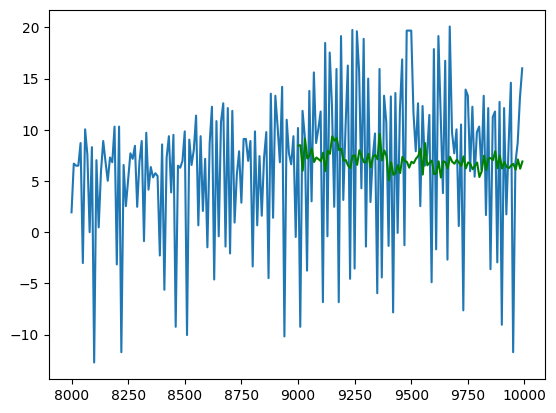

<Figure size 640x480 with 0 Axes>

In [34]:
print("Future Predictions:", future_predictions)
time = [data_set-m*step+i*step for i in range(2*m)]
print(m)
plt.plot(time, data['HUFL'].values[data_set-m*step:data_set+(m)*step:step])
#plt.plot(, )
pred = data['HUFL'].values[data_set-1]
time = [data_set+1+i*step for i in range(m)]

    
plt.plot(time, future_predictions, 'g-')

plt.show()



